<a href="https://colab.research.google.com/github/eleding24/AYSI-2020/blob/master/Trashnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN Neural Network 
Trained on trashnet dataset
https://github.com/garythung/trashnet 

code from 
https://nbviewer.jupyter.org/github/collindching/Waste-Sorter/blob/master/Waste%20sorter.ipynb

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

%config InlineBackend.figure_format = 'retina'

from fastai.vision import *
from fastai.metrics import error_rate
from pathlib import Path
from glob2 import glob
from sklearn.metrics import confusion_matrix

import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import re
import seaborn as sns
import zipfile as zf
import shutil
import zipfile

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [5]:
fileId = drive.CreateFile({'id': '1DchHTqcAefxyondZrtC939cI5I4zM9T0'}) #DRIVE_FILE_ID is 1DchHTqcAefxyondZrtC939cI5I4zM9T0
print(fileId['title'])  # folder_data.zip
fileId.GetContentFile('Trashnet.zip')  # Save Drive file as a local file

Trashnet.zip


In [ ]:
!unzip Trashnet.zip

In [7]:
folder_path = "/content/dataset-resized"

In [8]:
os.listdir(folder_path)

['plastic', 'trash', 'cardboard', 'metal', 'paper', 'glass', '.DS_Store']

In [9]:
## helper functions ##

## splits indices for a folder into train, validation, and test indices with random sampling
    ## input: folder path
    ## output: train, valid, and test indices    
def split_indices(folder,seed1,seed2):    
    n = len(os.listdir(folder))
    full_set = list(range(1,n+1))

    ## train indices
    random.seed(seed1)
    train = random.sample(list(range(1,n+1)),int(.5*n))

    ## temp
    remain = list(set(full_set)-set(train))

    ## separate remaining into validation and test
    random.seed(seed2)
    valid = random.sample(remain,int(.5*len(remain)))
    test = list(set(remain)-set(valid))
    
    return(train,valid,test)

## gets file names for a particular type of trash, given indices
    ## input: waste category and indices
    ## output: file names 
def get_names(waste_type,indices):
    file_names = [waste_type+str(i)+".jpg" for i in indices]
    return(file_names)    

## moves group of source files to another folder
    ## input: list of source files and destination folder
    ## no output
def move_files(source_files,destination_folder):
    for file in source_files:
        shutil.move(file,destination_folder)

In [10]:
## paths will be train/cardboard, train/glass, etc...
subsets = ['train','valid']
waste_types = ['cardboard','glass','metal','paper','plastic','trash']

## create destination folders for data subset and waste type
for subset in subsets:
    for waste_type in waste_types:
        folder = os.path.join('data',subset,waste_type)
        if not os.path.exists(folder):
            os.makedirs(folder)
            
if not os.path.exists(os.path.join('data','test')):
    os.makedirs(os.path.join('data','test'))
            
## move files to destination folders for each waste type
for waste_type in waste_types:
    source_folder = os.path.join('dataset-resized',waste_type)
    train_ind, valid_ind, test_ind = split_indices(source_folder,1,1)
    
    ## move source files to train
    train_names = get_names(waste_type,train_ind)
    train_source_files = [os.path.join(source_folder,name) for name in train_names]
    train_dest = "data/train/"+waste_type
    move_files(train_source_files,train_dest)
    
    ## move source files to valid
    valid_names = get_names(waste_type,valid_ind)
    valid_source_files = [os.path.join(source_folder,name) for name in valid_names]
    valid_dest = "data/valid/"+waste_type
    move_files(valid_source_files,valid_dest)
    
    ## move source files to test
    test_names = get_names(waste_type,test_ind)
    test_source_files = [os.path.join(source_folder,name) for name in test_names]
    ## I use data/test here because the images can be mixed up
    move_files(test_source_files,"data/test")

In [11]:
path = Path(os.getcwd())/"data"
path

PosixPath('/content/data')

In [12]:
tfms = get_transforms(do_flip=True,flip_vert=True)
data = ImageDataBunch.from_folder(path,test="test",ds_tfms=tfms,bs=16)

In [13]:
data

ImageDataBunch;

Train: LabelList (1262 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: CategoryList
plastic,plastic,plastic,plastic,plastic
Path: /content/data;

Valid: LabelList (630 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: CategoryList
plastic,plastic,plastic,plastic,plastic
Path: /content/data;

Test: LabelList (635 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: EmptyLabelList
,,,,
Path: /content/data

In [14]:
print(data.classes)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


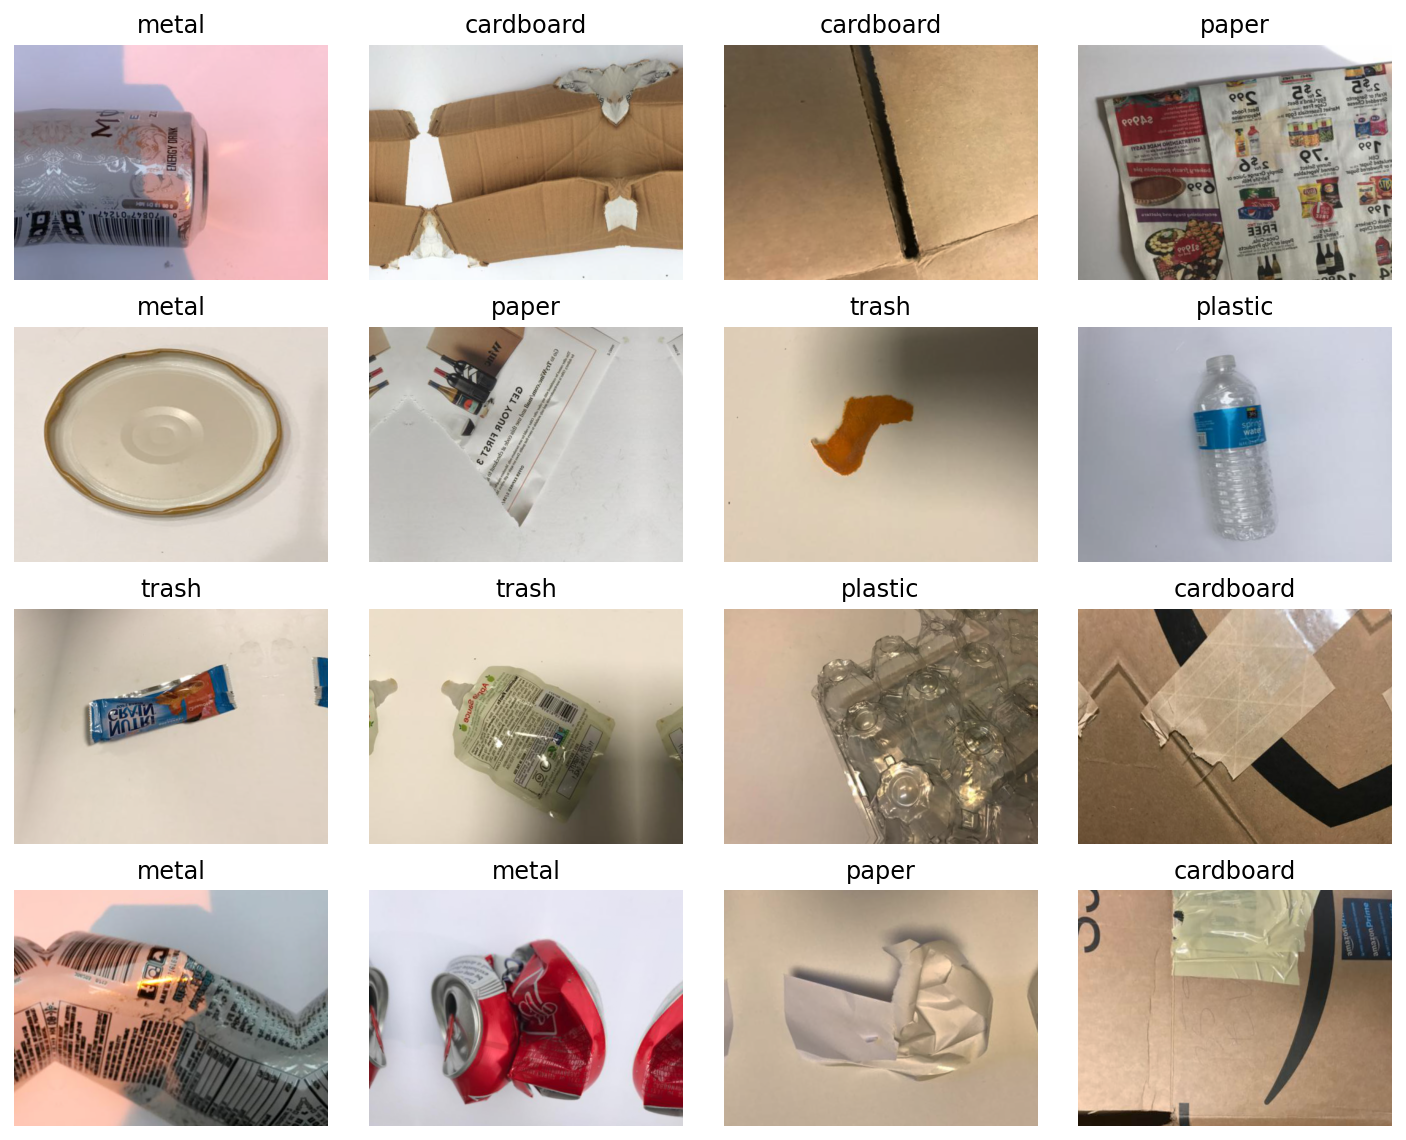

In [15]:
data.show_batch(rows=4,figsize=(10,8))

In [16]:
learn = create_cnn(data,models.resnet34,metrics=error_rate)

/usr/local/lib/python3.6/dist-packages/fastai/vision/learner.py:109: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")
Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [17]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


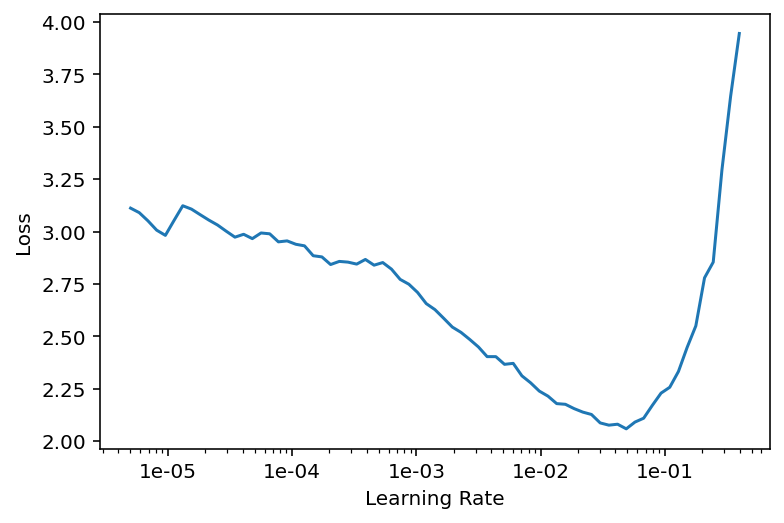

In [18]:
learn.lr_find(start_lr=1e-6,end_lr=1e1)
learn.recorder.plot()

In [19]:
learn.fit_one_cycle(20,max_lr=5.13e-03)

In [20]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()

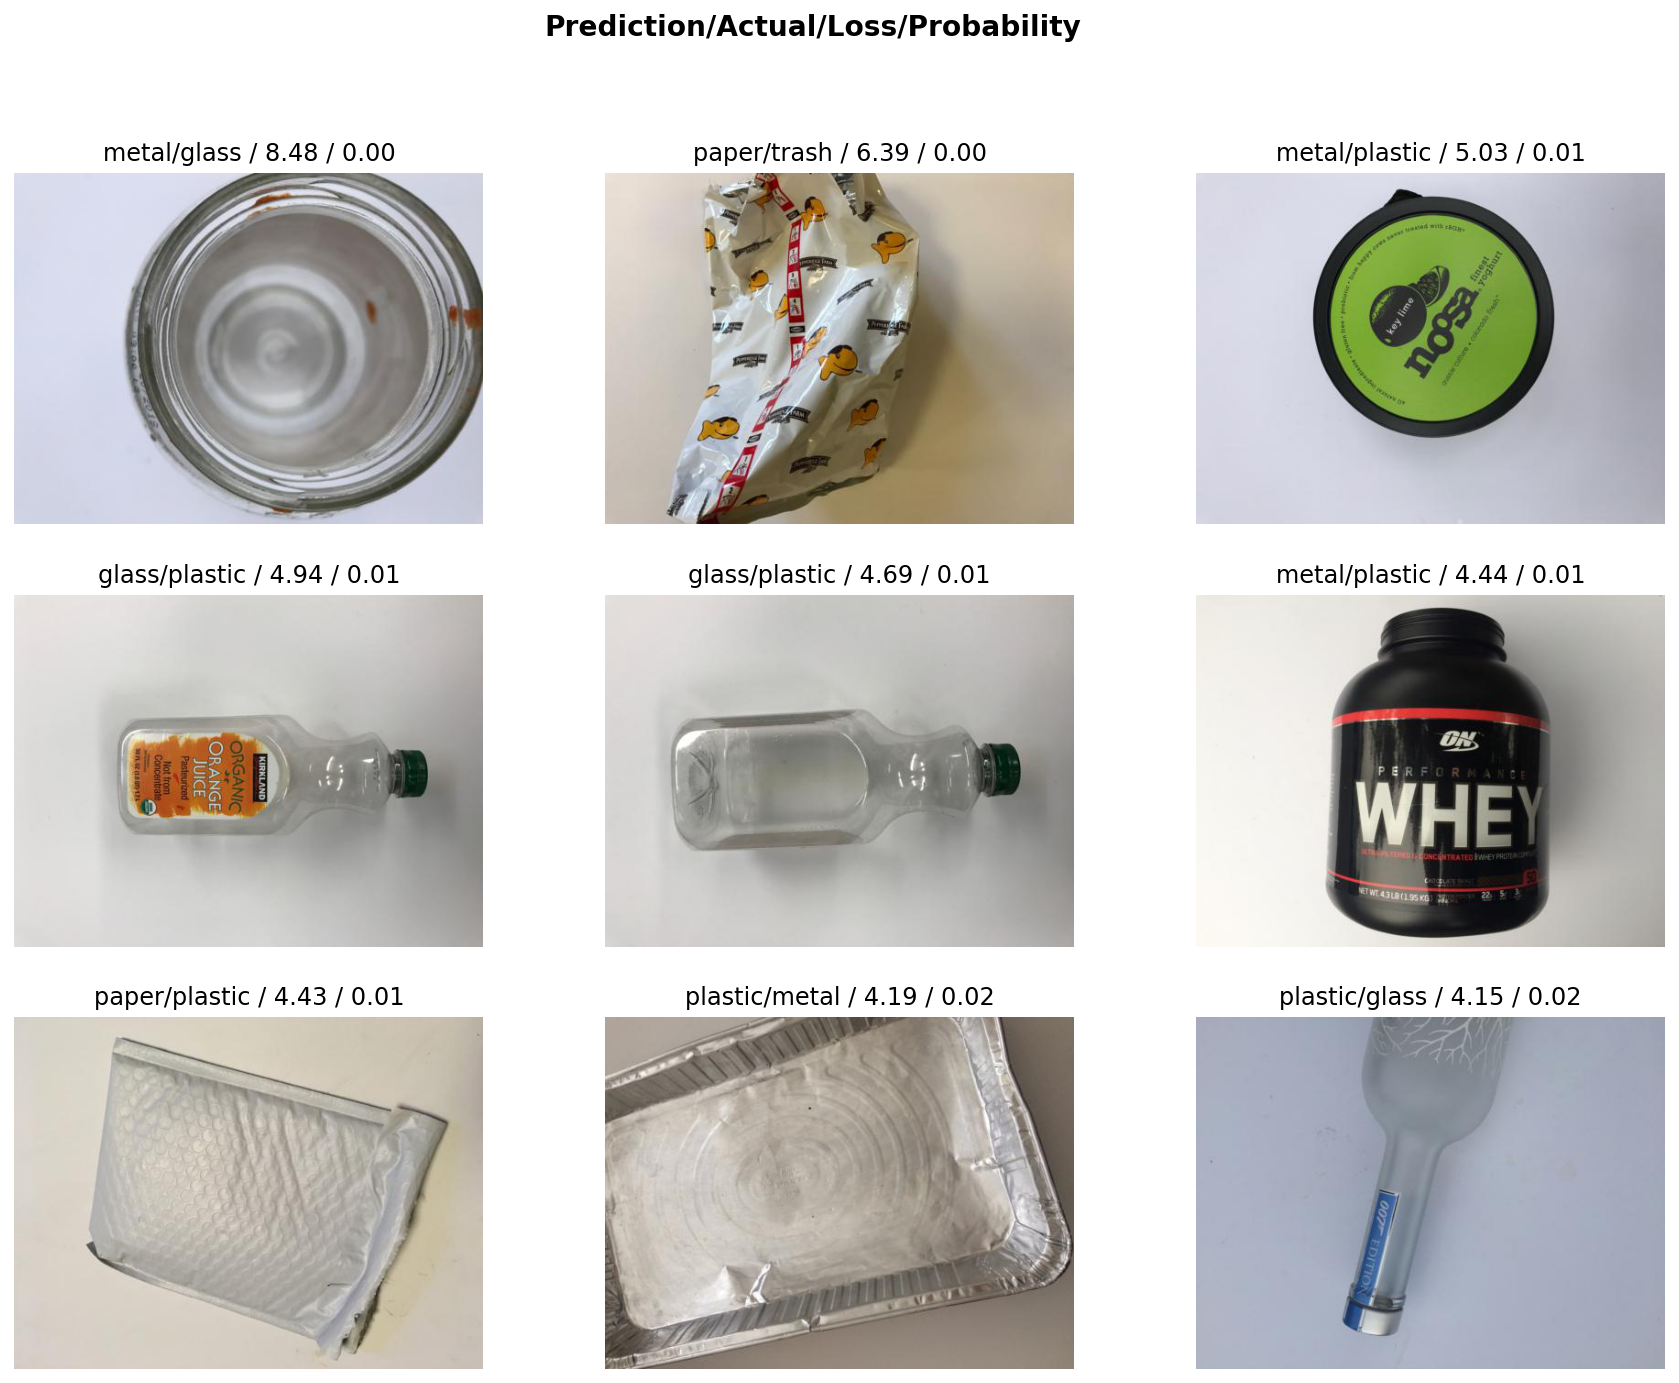

In [21]:
interp.plot_top_losses(9, figsize=(15,11))

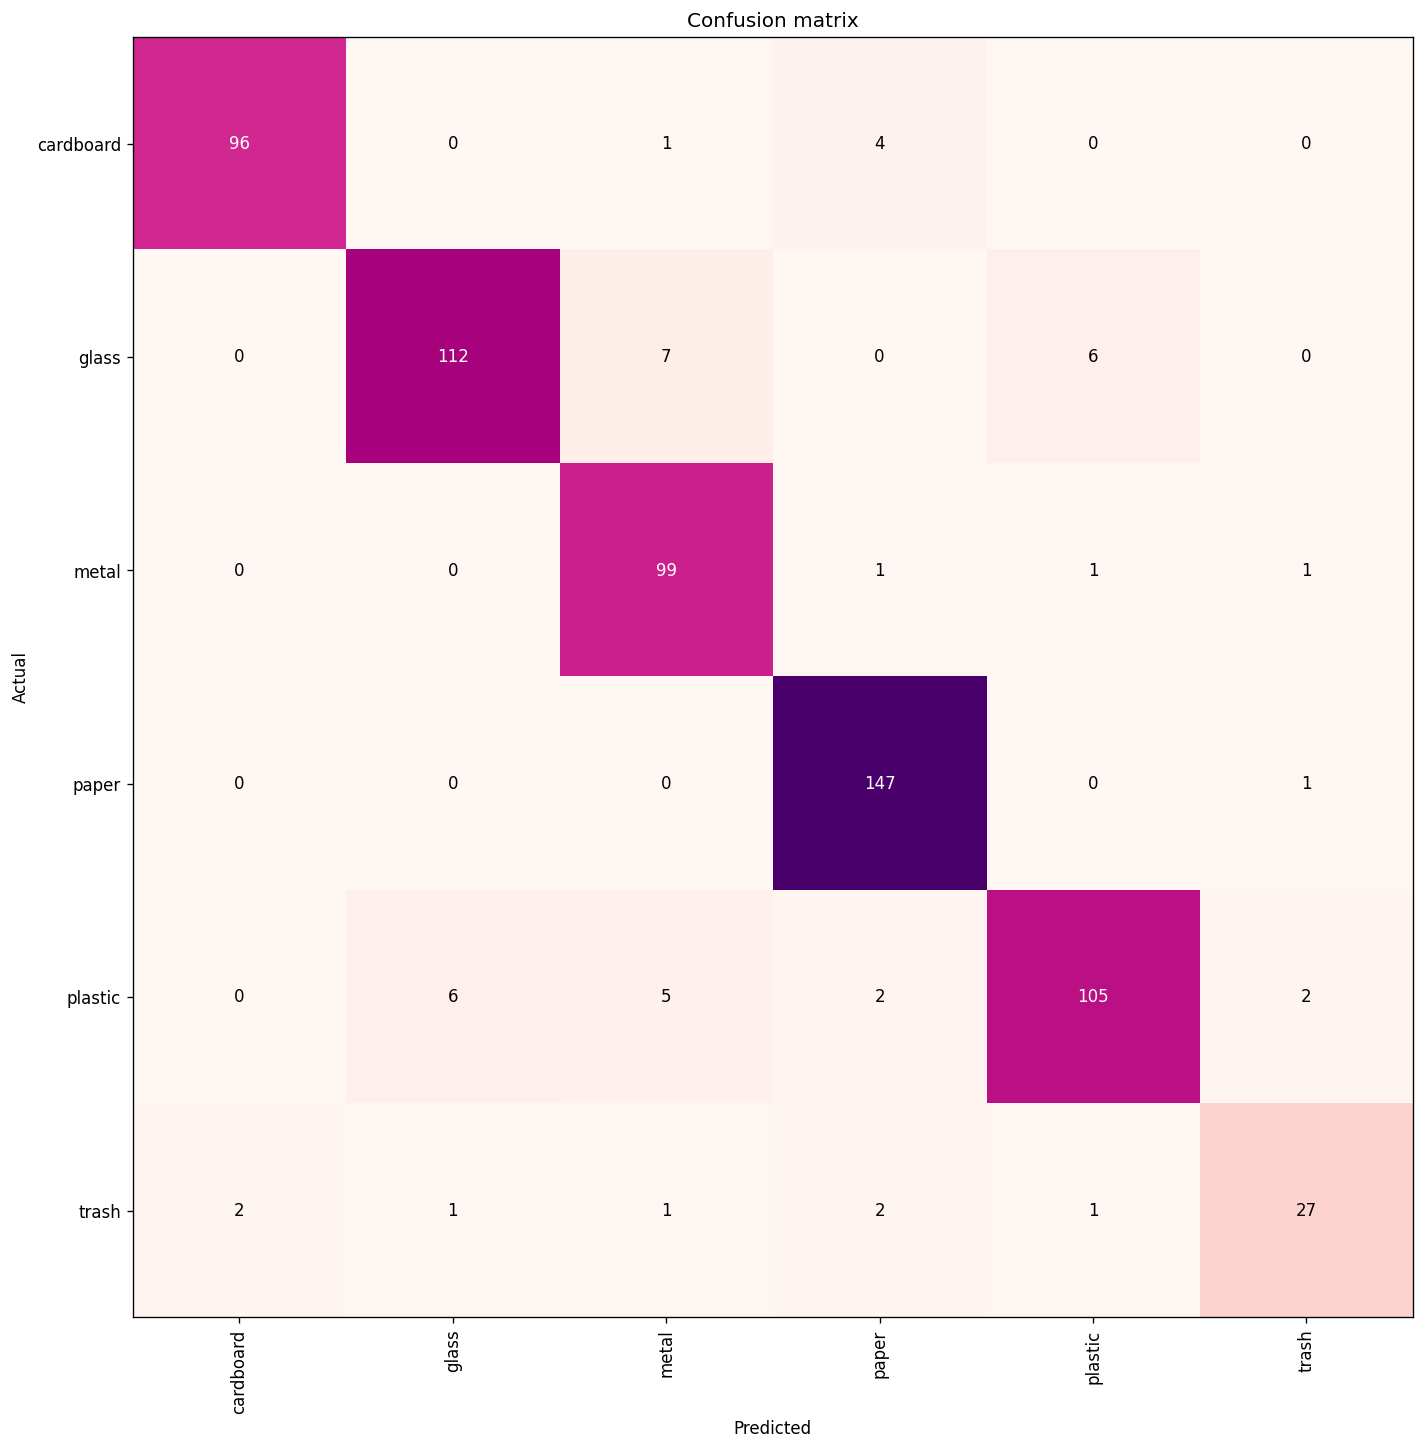

In [49]:
doc(interp.plot_top_losses)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60, cmap='RdPu')

In [23]:
interp.most_confused(min_val=2)

[('glass', 'metal', 7),
 ('glass', 'plastic', 6),
 ('plastic', 'glass', 6),
 ('plastic', 'metal', 5),
 ('cardboard', 'paper', 4),
 ('plastic', 'paper', 2),
 ('plastic', 'trash', 2),
 ('trash', 'cardboard', 2),
 ('trash', 'paper', 2)]

Making predictions

In [24]:
preds = learn.get_preds(ds_type=DatasetType.Test)

In [25]:
print(preds[0].shape)
preds[0]

torch.Size([635, 6])


tensor([[1.6496e-08, 3.1488e-09, 9.9991e-01, 7.9226e-06, 7.8842e-05, 1.3216e-06],
        [9.9855e-01, 2.8752e-06, 1.6563e-07, 1.3374e-03, 8.3054e-07, 1.0708e-04],
        [1.2156e-03, 6.2106e-04, 5.2195e-05, 9.9493e-01, 1.3978e-03, 1.7852e-03],
        ...,
        [4.9738e-03, 2.2040e-02, 6.0455e-05, 1.3043e-02, 8.5758e-01, 1.0230e-01],
        [9.4261e-09, 9.9680e-01, 2.6333e-03, 3.8157e-07, 5.6677e-04, 7.0527e-07],
        [4.2866e-06, 7.2210e-05, 3.6726e-06, 1.2085e-07, 9.9992e-01, 7.0617e-07]])

In [26]:
data.classes

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

In [27]:
# saves the index (0 to 5) of most likely (max) predicted class for each image
max_idxs = np.asarray(np.argmax(preds[0],axis=1))

In [28]:
yhat = []
for max_idx in max_idxs:
    yhat.append(data.classes[max_idx])

In [ ]:
yhat

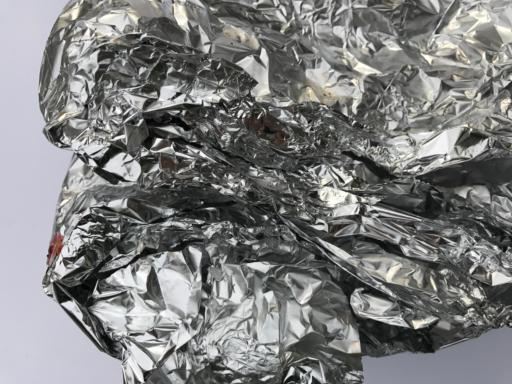

In [30]:
learn.data.test_ds[0][0]

In [31]:
y = []

## convert POSIX paths to string first
for label_path in data.test_ds.items:
    y.append(str(label_path))
    
## then extract waste type from file path
pattern = re.compile("([a-z]+)[0-9]+")
for i in range(len(y)):
    y[i] = pattern.search(y[i]).group(1)

In [32]:
## predicted values
print(yhat[0:5])
## actual values
print(y[0:5])

['metal', 'cardboard', 'paper', 'metal', 'paper']
['metal', 'cardboard', 'paper', 'metal', 'paper']


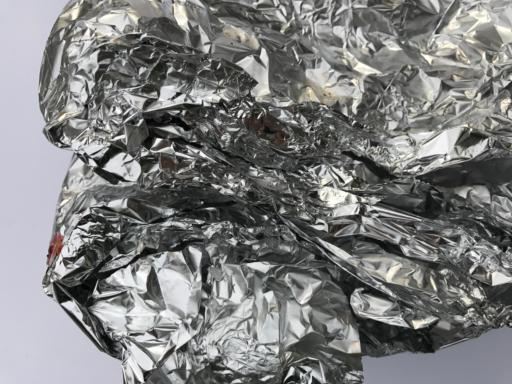

In [33]:
learn.data.test_ds[0][0]

In [34]:
cm = confusion_matrix(y,yhat)
print(cm)

[[ 95   1   1   4   0   0]
 [  0 111   9   0   6   0]
 [  1   8  89   0   2   3]
 [  0   0   1 143   1   4]
 [  0   0   1   0 116   4]
 [  1   0   2   5   1  26]]


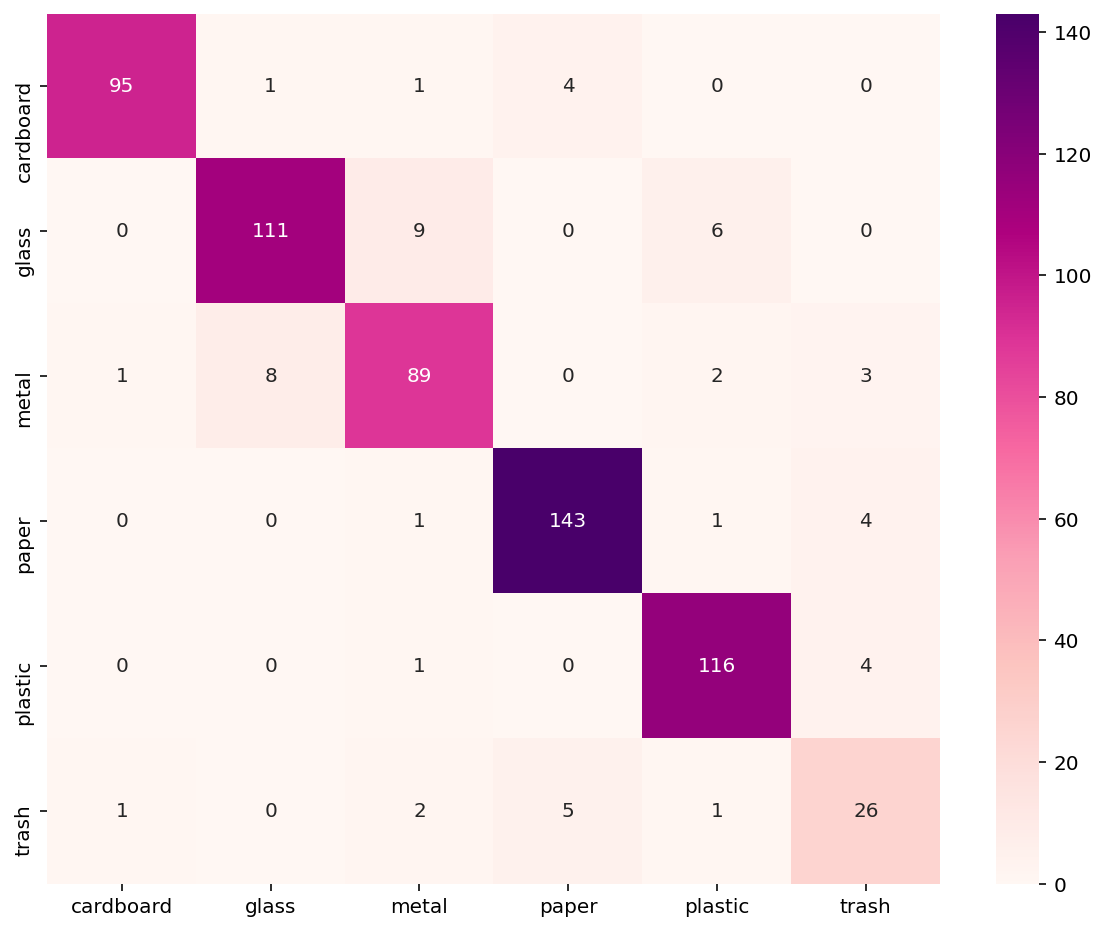

In [48]:
df_cm = pd.DataFrame(cm,waste_types,waste_types)

plt.figure(figsize=(10,8))
sns.heatmap(df_cm,annot=True,fmt="d",cmap="RdPu")


In [36]:
correct = 0

for r in range(len(cm)):
    for c in range(len(cm)):
        if (r==c):
            correct += cm[r,c]

In [37]:
accuracy = correct/sum(sum(cm))
accuracy

0.9133858267716536